# Replication for results in Davidson et al. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language"

In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

## Loading the data

In [2]:
df = pd.read_csv("../data/labeled_data.csv")

In [3]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [5]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


<AxesSubplot:>

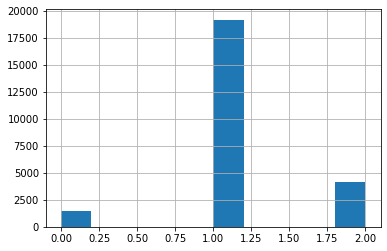

In [6]:
df['class'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [7]:
tweets=df.tweet

## Feature generation

In [332]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [333]:
print(df.iloc[0].tweet)
print(preprocess(df.iloc[0].tweet))
print(tokenize(preprocess(df.iloc[0].tweet)))
print(basic_tokenize(preprocess(df.iloc[0].tweet)))

!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
!!! RT : As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
['rt', 'as', 'a', 'woman', 'you', 'shouldn', 't', 'complain', 'about', 'clean', 'up', 'your', 'hous', 'amp', 'as', 'a', 'man', 'you', 'should', 'alway', 'take', 'the', 'trash', 'out']
['!!!', 'rt', 'as', 'a', 'woman', 'you', 'shouldn', 't', 'complain', 'about', 'cleaning', 'up', 'your', 'house.', 'amp', 'as', 'a', 'man', 'you', 'should', 'always', 'take', 'the', 'trash', 'out...']


In [334]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [335]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray() # tocanize and buid vocabulary
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/Users/rai00007/google-asr/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [347]:
# print(vectorizer.vocabulary_)
print(vocab['woman'])
print(tokenize(preprocess(df.iloc[0].tweet)))
vectorizer.transform(tokenize(preprocess(df.iloc[0].tweet))).toarray()[3][6894] # Extract value for 'women'

6894
['rt', 'as', 'a', 'woman', 'you', 'shouldn', 't', 'complain', 'about', 'clean', 'up', 'your', 'hous', 'amp', 'as', 'a', 'man', 'you', 'should', 'alway', 'take', 'the', 'trash', 'out']


6.483184225000979

In [348]:
vocab

{'ab': 0,
 'abil': 1,
 'abl': 2,
 'abo': 3,
 'abort': 4,
 'abov': 5,
 'absolut': 6,
 'abt': 7,
 'abu': 8,
 'abus': 9,
 'accent': 10,
 'accept': 11,
 'accid': 12,
 'accident': 13,
 'accord': 14,
 'account': 15,
 'accur': 16,
 'acknowledg': 17,
 'across': 18,
 'act': 19,
 'act like': 20,
 'act like bitch': 21,
 'act like hoe': 22,
 'act like pussi': 23,
 'actin': 24,
 'actin like': 25,
 'action': 26,
 'activ': 27,
 'actor': 28,
 'actual': 29,
 'actual fuck': 30,
 'ad': 31,
 'adam': 32,
 'add': 33,
 'addict': 34,
 'address': 35,
 'admit': 36,
 'adopt': 37,
 'ador': 38,
 'adult': 39,
 'advanc': 40,
 'advic': 41,
 'ae': 42,
 'af': 43,
 'affect': 44,
 'afford': 45,
 'afraid': 46,
 'african': 47,
 'afterward': 48,
 'ag': 49,
 'age': 50,
 'ago': 51,
 'agre': 52,
 'ah': 53,
 'ah bitch': 54,
 'aha': 55,
 'ahaha': 56,
 'ahead': 57,
 'ahh': 58,
 'ahhh': 59,
 'aid': 60,
 'aim': 61,
 'ainn': 62,
 'aint': 63,
 'aint bitch': 64,
 'aint even': 65,
 'aint fuck': 66,
 'aint fuckin': 67,
 'aint get': 68,


In [349]:
text = ["The quick brown fox jumped over the lazy dog.",
		"The dog.",
		"The fox"]

tfidf_text = vectorizer.transform(text).toarray()
print(tfidf_text.shape)
print(tfidf_text)
# print(vectorizer.vocabulary_)

(3, 7086)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [350]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [351]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [352]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}
print(pos.shape)

(24783, 4069)


In [353]:
pos_vocab

{'CC': 0,
 'CC CC': 1,
 'CC CD': 2,
 'CC CD NN': 3,
 'CC DT': 4,
 'CC DT CC': 5,
 'CC DT IN': 6,
 'CC DT JJ': 7,
 'CC DT NN': 8,
 'CC DT NNS': 9,
 'CC DT PRP': 10,
 'CC DT RB': 11,
 'CC DT VBD': 12,
 'CC DT VBP': 13,
 'CC DT VBZ': 14,
 'CC EX': 15,
 'CC IN': 16,
 'CC IN DT': 17,
 'CC IN JJ': 18,
 'CC IN NN': 19,
 'CC IN NNS': 20,
 'CC IN PRP': 21,
 'CC IN VBP': 22,
 'CC JJ': 23,
 'CC JJ CC': 24,
 'CC JJ DT': 25,
 'CC JJ IN': 26,
 'CC JJ JJ': 27,
 'CC JJ MD': 28,
 'CC JJ NN': 29,
 'CC JJ NNS': 30,
 'CC JJ PRP': 31,
 'CC JJ RB': 32,
 'CC JJ TO': 33,
 'CC JJ VB': 34,
 'CC JJ VBD': 35,
 'CC JJ VBN': 36,
 'CC JJ VBP': 37,
 'CC JJ VBZ': 38,
 'CC JJR': 39,
 'CC JJS': 40,
 'CC MD': 41,
 'CC MD RB': 42,
 'CC MD VB': 43,
 'CC NN': 44,
 'CC NN CC': 45,
 'CC NN DT': 46,
 'CC NN IN': 47,
 'CC NN JJ': 48,
 'CC NN MD': 49,
 'CC NN NN': 50,
 'CC NN NNS': 51,
 'CC NN PRP': 52,
 'CC NN RB': 53,
 'CC NN TO': 54,
 'CC NN VB': 55,
 'CC NN VBD': 56,
 'CC NN VBG': 57,
 'CC NN VBP': 58,
 'CC NN VBZ': 59,
 'CC

In [354]:
text_tag = []
for t in text:
    tockens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    text_tag.append(tag_str)
    
#Construct POS TF matrix and get vocab dict
pos_text = pos_vectorizer.transform(pd.Series(text_tag)).toarray()
print(pos_text.shape)
print(pos_text)

(3, 4069)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [355]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [356]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [357]:
feats = get_feature_array(tweets)

In [358]:
print(tfidf.shape,pos.shape,feats.shape)

(24783, 7086) (24783, 4069) (24783, 17)


In [359]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)
print(M.shape)

(24783, 11172)


In [360]:
feats_text = get_feature_array(text)
M_text = np.concatenate([tfidf_text,pos_text,feats_text],axis=1)
print(M_text.shape)

(3, 11172)


In [361]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [362]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [363]:
from sklearn.model_selection import train_test_split

In [364]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [365]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [366]:
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l2", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [367]:
param_grid = [{}] # Optionally add parameters here

In [368]:
grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=2)

In [369]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/rai00007/google-asr/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rai00007/google-asr/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative so

[CV] ................................................. , total=  32.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.0s remaining:    0.0s
/Users/rai00007/google-asr/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rai00007/google-asr/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

[CV] ................................................. , total=  30.7s
[CV]  ................................................................


/Users/rai00007/google-asr/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rai00007/google-asr/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV] ................................................. , total=  30.5s
[CV]  ................................................................


/Users/rai00007/google-asr/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rai00007/google-asr/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV] ................................................. , total=  29.8s
[CV]  ................................................................


/Users/rai00007/google-asr/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rai00007/google-asr/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV] ................................................. , total=  31.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished
/Users/rai00007/google-asr/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rai00007/google-asr/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

In [370]:
y_preds = model.predict(X_test)
print(y_preds)

[1 1 2 ... 1 2 1]


## Evaluating the results

In [371]:
report = classification_report( y_test, y_preds )

***Note: Results in paper are from best model retrained on the entire dataset (see the other notebook). Here the results are reported after using cross-validation and only for the held-out set.***

In [372]:
print(report)

              precision    recall  f1-score   support

           0       0.30      0.71      0.42       164
           1       0.97      0.83      0.89      1905
           2       0.79      0.90      0.84       410

    accuracy                           0.83      2479
   macro avg       0.69      0.81      0.72      2479
weighted avg       0.90      0.83      0.85      2479



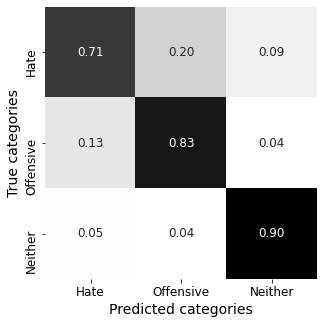

In [373]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

<AxesSubplot:>

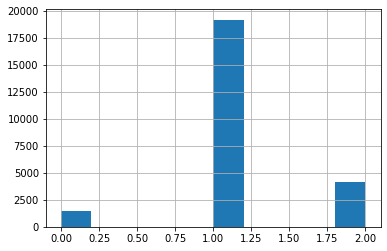

In [374]:
#True distribution
y.hist()

<AxesSubplot:>

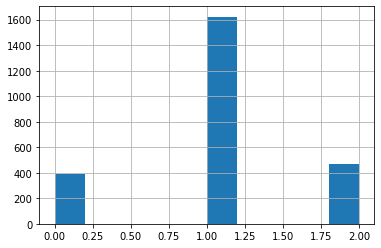

In [375]:
pd.Series(y_preds).hist()

In [377]:
text = ["The quick brown fox jumped over the lazy dog.",
		"The dog.",
		"The fox",
        "You are too dumb",
        "He’s so dumb!"
       ]

tfidf_text = vectorizer.transform(text).toarray()

text_tag = []
for t in text:
    tockens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    text_tag.append(tag_str)
    
#Construct POS TF matrix and get vocab dict
pos_text = pos_vectorizer.transform(pd.Series(text_tag)).toarray()
feats_text = get_feature_array(text)
M_text = np.concatenate([tfidf_text,pos_text,feats_text],axis=1)
print(M_text.shape)

X_text = pd.DataFrame(M_text)
y_text = model.predict(X_text)
print(y_text)

(5, 11172)
[2 2 2 1 1]
